# Testing Other Models for Poverty Prediction

This notebook explores alternative models to XGBoost, starting with **CatBoost**.

## Why CatBoost?
- **Native categorical support** - no need for label encoding or one-hot encoding
- **Built-in class imbalance handling** - `auto_class_weights` parameter
- **Often outperforms XGBoost** on categorical-heavy datasets
- **Less hyperparameter tuning needed** - good defaults
- **Excellent interpretability** - feature importance and SHAP support

In [1]:
# Install CatBoost
!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [3]:
# Load Data
df_train = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_test = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")

Train shape: (1469769, 27)
Test shape: (304368, 27)

Columns: ['PUMA', 'AGEP', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'POVPIP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'year', 'poverty_risk_score', 'CA_Region']


## 2. Preprocessing for CatBoost

**Key difference from XGBoost**: CatBoost handles categorical features natively!
- No label encoding needed
- Just tell CatBoost which columns are categorical
- It uses an efficient encoding internally (ordered target encoding)

In [4]:
def preprocess_for_catboost(df):
    """
    Minimal preprocessing for CatBoost.
    CatBoost handles categoricals natively - just need to:
    1. Fill nulls with explicit values (CatBoost doesn't handle NaN in cat features)
    2. Convert categorical columns to string type
    """
    df = df.copy()
    
    # Fill nulls based on ACS documentation
    df['ENG'] = df['ENG'].fillna(0)       # 0 = speaks only English
    df['LANP'] = df['LANP'].fillna(9999)  # 9999 = Other/unspecified
    df['WKHP'] = df['WKHP'].fillna(0)     # 0 = did not work
    df['WRK'] = df['WRK'].fillna(0)       # 0 = N/A
    df['OCCP'] = df['OCCP'].fillna('NILF') # Not in Labor Force
    
    # Define categorical columns
    categorical_cols = [
        'PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK',
        'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
        'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year'
    ]
    
    # Convert categorical columns to string (CatBoost requirement)
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    return df, categorical_cols

# Apply preprocessing
df_train_processed, cat_features = preprocess_for_catboost(df_train)
df_test_processed, _ = preprocess_for_catboost(df_test)

print(f"Categorical features ({len(cat_features)}): {cat_features}")

Categorical features (22): ['PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year']


In [5]:
# Prepare features and target
exclude_cols = ['POVPIP', 'poverty_risk_score']
feature_cols = [c for c in df_train_processed.columns if c not in exclude_cols]

# Get indices of categorical features (CatBoost needs this)
cat_feature_indices = [feature_cols.index(c) for c in cat_features if c in feature_cols]

X_train = df_train_processed[feature_cols]
y_train = df_train_processed['poverty_risk_score'].astype(int)

X_test = df_test_processed[feature_cols]
y_test = df_test_processed['poverty_risk_score'].astype(int)

print(f"Features: {len(feature_cols)}")
print(f"Categorical features: {len(cat_feature_indices)}")
print(f"\nClass distribution:")
print(y_train.value_counts().sort_index())

Features: 25
Categorical features: 22

Class distribution:
poverty_risk_score
0    1114746
1     196583
2      78995
3      79445
Name: count, dtype: int64


## 3. CatBoost Multi-class Classification

Using `auto_class_weights='Balanced'` to handle class imbalance automatically.

In [6]:
# Create CatBoost Pool (efficient data structure)
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_feature_indices
)

print("CatBoost Pools created!")

CatBoost Pools created!


In [7]:
# CatBoost Multi-class Model
model_catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    auto_class_weights='Balanced',  # Handle class imbalance
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

print("Training CatBoost multi-class model...")
model_catboost.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

print("\nTraining complete!")

Training CatBoost multi-class model...
0:	learn: 1.3433938	test: 1.3438802	best: 1.3438802 (0)	total: 1.85s	remaining: 15m 21s
100:	learn: 1.0948602	test: 1.1177887	best: 1.1177887 (100)	total: 3m 15s	remaining: 12m 52s
200:	learn: 1.0762934	test: 1.1094911	best: 1.1094911 (200)	total: 6m 34s	remaining: 9m 46s
300:	learn: 1.0666793	test: 1.1080195	best: 1.1080195 (300)	total: 9m 50s	remaining: 6m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.107352158
bestIteration = 344

Shrink model to first 345 iterations.

Training complete!


In [8]:
# Evaluate Multi-class Model
y_pred_multi = model_catboost.predict(test_pool).flatten().astype(int)

class_names = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']
print("=== CatBoost Multi-class Results ===")
print(classification_report(y_test, y_pred_multi, target_names=class_names))

=== CatBoost Multi-class Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.94      0.68      0.79    233793
Near Poverty (1)       0.24      0.46      0.31     38456
     Poverty (2)       0.18      0.35      0.23     15534
Deep Poverty (3)       0.28      0.53      0.36     16585

        accuracy                           0.62    304368
       macro avg       0.41      0.50      0.42    304368
    weighted avg       0.77      0.62      0.68    304368



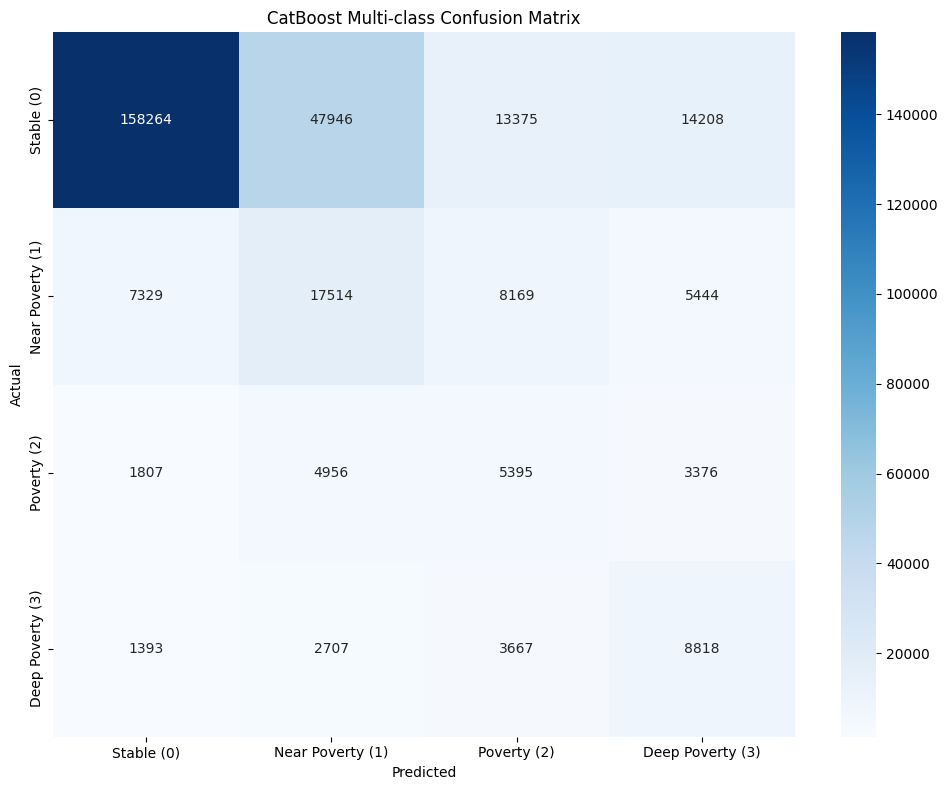

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_multi)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost Multi-class Confusion Matrix')
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_multiclass_confusion.png', dpi=150)
plt.show()

## 4. CatBoost Binary Classification (Stable vs At-Risk)

Simplifying to binary classification often yields better results for policy applications.

In [10]:
# Create binary target: 0 = Stable, 1 = At-Risk (any poverty level)
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

print("Binary class distribution (Train):")
print(y_train_binary.value_counts())
print(f"\nAt-Risk percentage: {y_train_binary.mean()*100:.1f}%")

Binary class distribution (Train):
poverty_risk_score
0    1114746
1     355023
Name: count, dtype: int64

At-Risk percentage: 24.2%


In [11]:
# Binary Pools
train_pool_binary = Pool(
    data=X_train,
    label=y_train_binary,
    cat_features=cat_feature_indices
)

test_pool_binary = Pool(
    data=X_test,
    label=y_test_binary,
    cat_features=cat_feature_indices
)

In [12]:
# CatBoost Binary Model
model_catboost_binary = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

print("Training CatBoost binary model...")
model_catboost_binary.fit(
    train_pool_binary,
    eval_set=test_pool_binary,
    use_best_model=True
)

print("\nTraining complete!")

Training CatBoost binary model...
0:	learn: 0.6568858	test: 0.6570190	best: 0.6570190 (0)	total: 429ms	remaining: 3m 34s
100:	learn: 0.4776317	test: 0.4889350	best: 0.4888853 (99)	total: 31.5s	remaining: 2m 4s
200:	learn: 0.4709682	test: 0.4861756	best: 0.4861756 (200)	total: 1m 3s	remaining: 1m 34s
300:	learn: 0.4674083	test: 0.4852232	best: 0.4851530 (271)	total: 1m 33s	remaining: 1m 1s
400:	learn: 0.4652572	test: 0.4843336	best: 0.4839196 (359)	total: 2m 4s	remaining: 30.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4839195655
bestIteration = 359

Shrink model to first 360 iterations.

Training complete!


In [13]:
# Evaluate Binary Model
y_pred_binary = model_catboost_binary.predict(test_pool_binary).flatten().astype(int)

binary_names = ['Stable', 'At-Risk']
print("=== CatBoost Binary Classification Results ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_names))

=== CatBoost Binary Classification Results ===
              precision    recall  f1-score   support

      Stable       0.93      0.73      0.82    233793
     At-Risk       0.47      0.82      0.60     70575

    accuracy                           0.75    304368
   macro avg       0.70      0.77      0.71    304368
weighted avg       0.82      0.75      0.77    304368



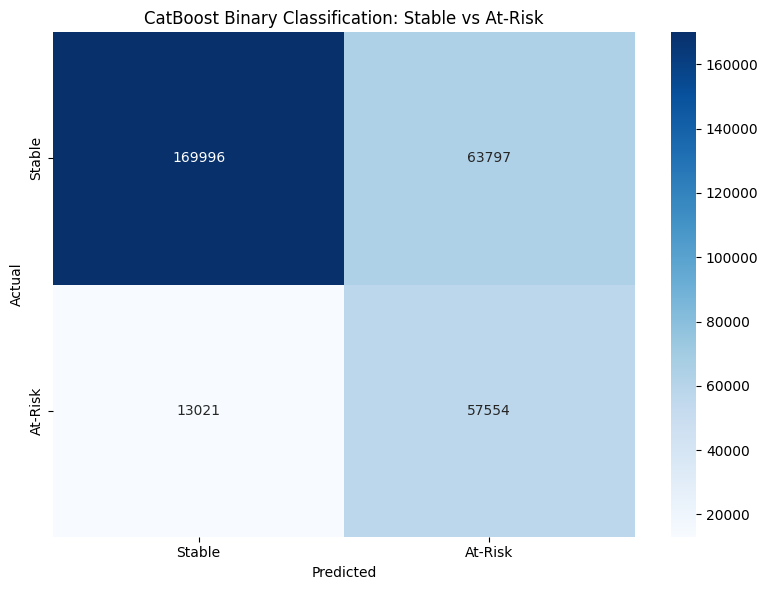

In [14]:
# Binary Confusion Matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_names, yticklabels=binary_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost Binary Classification: Stable vs At-Risk')
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_binary_confusion.png', dpi=150)
plt.show()

## 5. Feature Importance Analysis

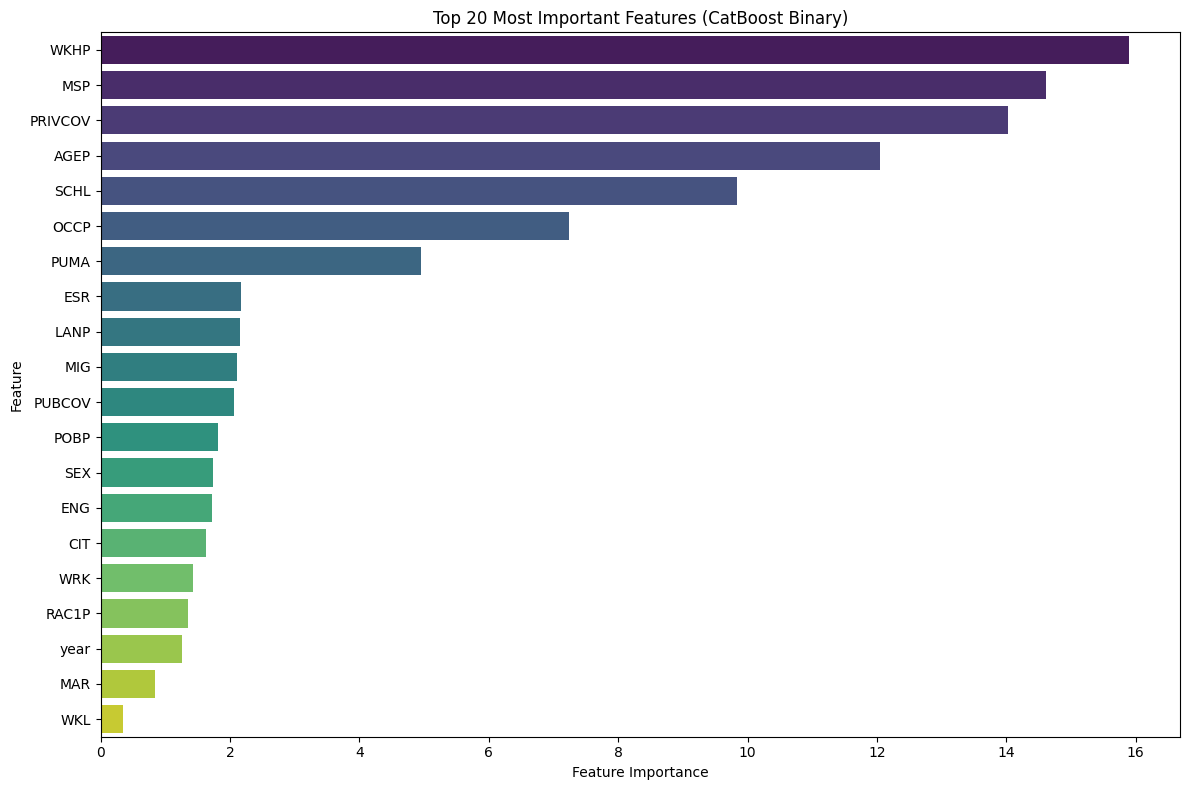


Top 15 Features:
feature  importance
   WKHP   15.890324
    MSP   14.614621
PRIVCOV   14.032704
   AGEP   12.045819
   SCHL    9.836348
   OCCP    7.237797
   PUMA    4.950541
    ESR    2.169069
   LANP    2.146468
    MIG    2.101717
 PUBCOV    2.059328
   POBP    1.820701
    SEX    1.730468
    ENG    1.719451
    CIT    1.626518


In [15]:
# Feature importance from binary model (usually more interpretable)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_catboost_binary.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features (CatBoost Binary)')
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_feature_importance.png', dpi=150)
plt.show()

print("\nTop 15 Features:")
print(importance_df.head(15).to_string(index=False))

## 6. Model Comparison Summary

In [16]:
# Compile results
results = []

# CatBoost Multi-class
results.append({
    'Model': 'CatBoost Multi-class',
    'Task': '4-class',
    'Macro F1': f1_score(y_test, y_pred_multi, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_multi, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_multi)
})

# CatBoost Binary
results.append({
    'Model': 'CatBoost Binary',
    'Task': 'Binary',
    'Macro F1': f1_score(y_test_binary, y_pred_binary, average='macro'),
    'Weighted F1': f1_score(y_test_binary, y_pred_binary, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_binary, y_pred_binary)
})

results_df = pd.DataFrame(results)
print("=== CatBoost Results Summary ===")
print(results_df.to_string(index=False))

=== CatBoost Results Summary ===
               Model    Task  Macro F1  Weighted F1  Balanced Accuracy
CatBoost Multi-class 4-class  0.424542     0.675371           0.502840
     CatBoost Binary  Binary  0.707726     0.765627           0.771312


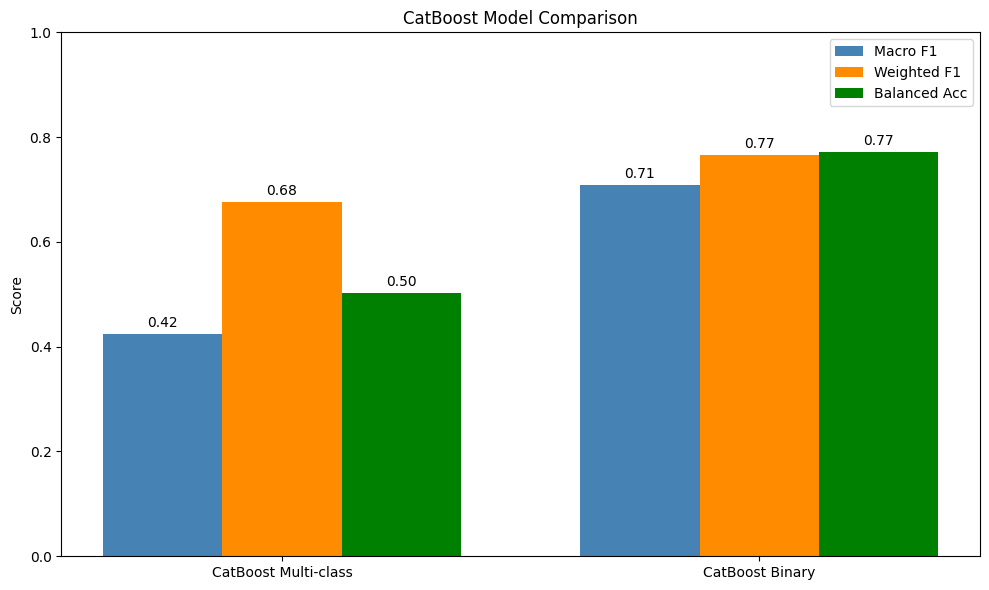

In [17]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x - width, results_df['Macro F1'], width, label='Macro F1', color='steelblue')
bars2 = ax.bar(x, results_df['Weighted F1'], width, label='Weighted F1', color='darkorange')
bars3 = ax.bar(x + width, results_df['Balanced Accuracy'], width, label='Balanced Acc', color='green')

ax.set_ylabel('Score')
ax.set_title('CatBoost Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.legend()
ax.set_ylim(0, 1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('preprocessing_data/catboost_comparison.png', dpi=150)
plt.show()

## 7. Threshold Tuning for Binary Model

Adjusting the classification threshold to optimize for recall (catching more at-risk individuals).

In [18]:
# Get probabilities
y_proba_binary = model_catboost_binary.predict_proba(test_pool_binary)[:, 1]

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6]
print("=== Threshold Analysis ===")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 48)

for thresh in thresholds:
    y_pred_thresh = (y_proba_binary >= thresh).astype(int)
    from sklearn.metrics import precision_score, recall_score
    prec = precision_score(y_test_binary, y_pred_thresh)
    rec = recall_score(y_test_binary, y_pred_thresh)
    f1 = f1_score(y_test_binary, y_pred_thresh)
    print(f"{thresh:<12} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")

=== Threshold Analysis ===
Threshold    Precision    Recall       F1          
------------------------------------------------
0.3          0.375        0.925        0.534       
0.4          0.425        0.876        0.573       
0.5          0.474        0.816        0.600       
0.6          0.523        0.740        0.613       


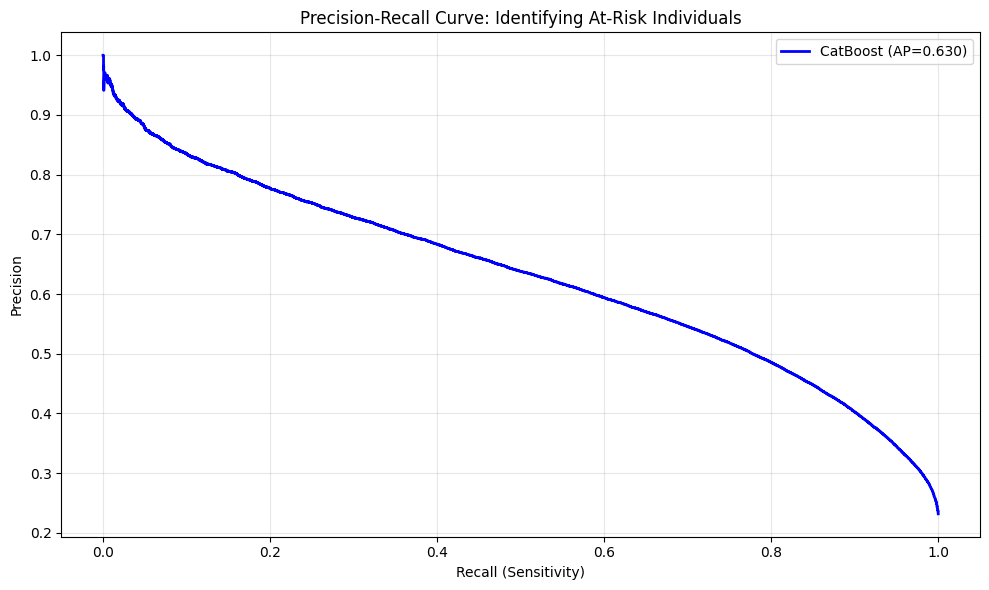


Average Precision Score: 0.630


In [19]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds_pr = precision_recall_curve(y_test_binary, y_proba_binary)
ap = average_precision_score(y_test_binary, y_proba_binary)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', lw=2, label=f'CatBoost (AP={ap:.3f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Identifying At-Risk Individuals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_pr_curve.png', dpi=150)
plt.show()

print(f"\nAverage Precision Score: {ap:.3f}")

## 8. Save Models

In [20]:
# Save models
model_catboost.save_model('preprocessing_data/catboost_multiclass.cbm')
model_catboost_binary.save_model('preprocessing_data/catboost_binary.cbm')

print("Models saved:")
print("  - preprocessing_data/catboost_multiclass.cbm")
print("  - preprocessing_data/catboost_binary.cbm")

Models saved:
  - preprocessing_data/catboost_multiclass.cbm
  - preprocessing_data/catboost_binary.cbm


## Summary

### CatBoost Advantages Observed:
1. **No preprocessing needed** for categorical features - native support
2. **Built-in class balancing** - `auto_class_weights='Balanced'`
3. **Early stopping** prevents overfitting automatically
4. **Fast training** compared to XGBoost on categorical-heavy data

### Key Findings:
- Binary classification (Stable vs At-Risk) significantly outperforms multi-class
- Threshold tuning can optimize for recall (catching more at-risk individuals)
- Feature importance aligns with domain knowledge (WKHP, AGEP, SCHL most important)

---

# LightGBM Model for Poverty Prediction

## Why LightGBM?
- **Histogram-based splitting** — bins continuous features for faster training
- **Leaf-wise tree growth** — grows the leaf with the highest loss reduction (vs XGBoost's level-wise)
- **Very fast** on large datasets — often 2-10x faster than XGBoost
- **Lower memory usage** — efficient histogram representation
- **Native categorical support** (like CatBoost, unlike XGBoost)
- **Built-in class imbalance handling** via `is_unbalance` or `class_weight`

In [21]:
!pip install lightgbm -q

In [22]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print(f"LightGBM version: {lgb.__version__}")

LightGBM version: 4.6.0


## 9. Preprocessing for LightGBM

LightGBM supports native categorical features (like CatBoost), but requires them to be
encoded as `category` dtype in pandas. We'll use this native support rather than label encoding.

In [23]:
def preprocess_for_lightgbm(df):
    """
    Preprocessing for LightGBM with native categorical support.
    - Fill nulls based on ACS documentation
    - Convert categorical columns to pandas 'category' dtype
    """
    df = df.copy()
    
    # Fill nulls based on ACS documentation
    df['ENG'] = df['ENG'].fillna(0)       # 0 = speaks only English
    df['LANP'] = df['LANP'].fillna(9999)  # 9999 = Other/unspecified
    df['WKHP'] = df['WKHP'].fillna(0)     # 0 = did not work
    df['WRK'] = df['WRK'].fillna(0)       # 0 = N/A
    df['OCCP'] = df['OCCP'].fillna('NILF') # Not in Labor Force
    
    categorical_cols = [
        'PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK',
        'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
        'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year'
    ]
    
    # Convert to pandas category dtype (LightGBM's native categorical support)
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).astype('category')
    
    return df, categorical_cols

# Reload raw data fresh (CatBoost preprocessing converted to string, need category dtype)
df_train_lgb = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_test_lgb = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')

df_train_lgb, lgb_cat_features = preprocess_for_lightgbm(df_train_lgb)
df_test_lgb, _ = preprocess_for_lightgbm(df_test_lgb)

# Align categories between train and test so LightGBM doesn't error on unseen categories
for col in lgb_cat_features:
    if col in df_train_lgb.columns:
        all_cats = set(df_train_lgb[col].cat.categories) | set(df_test_lgb[col].cat.categories)
        df_train_lgb[col] = df_train_lgb[col].cat.set_categories(all_cats)
        df_test_lgb[col] = df_test_lgb[col].cat.set_categories(all_cats)

# Prepare features and target
exclude_cols = ['POVPIP', 'poverty_risk_score']
lgb_feature_cols = [c for c in df_train_lgb.columns if c not in exclude_cols]

X_train_lgb = df_train_lgb[lgb_feature_cols]
y_train_lgb = df_train_lgb['poverty_risk_score'].astype(int)

X_test_lgb = df_test_lgb[lgb_feature_cols]
y_test_lgb = df_test_lgb['poverty_risk_score'].astype(int)

print(f"Train: {X_train_lgb.shape}, Test: {X_test_lgb.shape}")
print(f"Categorical features: {len(lgb_cat_features)}")
print(f"\nClass distribution:")
print(y_train_lgb.value_counts().sort_index())

Train: (1469769, 25), Test: (304368, 25)
Categorical features: 22

Class distribution:
poverty_risk_score
0    1114746
1     196583
2      78995
3      79445
Name: count, dtype: int64


## 10. LightGBM Multi-class Classification

Using `is_unbalance=True` to automatically handle class imbalance, plus early stopping.

In [24]:
# Compute sample weights (inverse frequency) for multi-class
lgb_class_counts = y_train_lgb.value_counts().sort_index()
lgb_total = len(y_train_lgb)
lgb_n_classes = len(lgb_class_counts)
lgb_class_weights = {i: lgb_total / (lgb_n_classes * count) for i, count in lgb_class_counts.items()}
lgb_sample_weights = y_train_lgb.map(lgb_class_weights).values

print(f"Class weights: {lgb_class_weights}")

# LightGBM Multi-class Model
model_lgb_multi = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,
    metric='multi_logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1  # suppress iteration output
)

print("\nTraining LightGBM multi-class model...")
model_lgb_multi.fit(
    X_train_lgb, y_train_lgb,
    sample_weight=lgb_sample_weights,
    eval_set=[(X_test_lgb, y_test_lgb)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=True),
        lgb.log_evaluation(period=50)
    ]
)

y_pred_lgb_multi = model_lgb_multi.predict(X_test_lgb)

class_names = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']
print(f"\nBest iteration: {model_lgb_multi.best_iteration_}")
print("\n=== LightGBM Multi-class Results ===")
print(classification_report(y_test_lgb, y_pred_lgb_multi, target_names=class_names))

Class weights: {0: 0.32961970709022503, 1: 1.869145602620776, 2: 4.65146211785556, 3: 4.625114859336648}

Training LightGBM multi-class model...
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.96207
[100]	valid_0's multi_logloss: 0.945525
[150]	valid_0's multi_logloss: 0.937085
[200]	valid_0's multi_logloss: 0.929823
[250]	valid_0's multi_logloss: 0.924477
[300]	valid_0's multi_logloss: 0.920013
[350]	valid_0's multi_logloss: 0.915814
[400]	valid_0's multi_logloss: 0.911698
[450]	valid_0's multi_logloss: 0.908201
[500]	valid_0's multi_logloss: 0.904957
Did not meet early stopping. Best iteration is:
[497]	valid_0's multi_logloss: 0.904943

Best iteration: 497

=== LightGBM Multi-class Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.93      0.71      0.80    233793
Near Poverty (1)       0.25      0.40      0.31     38456
     Poverty (2)       0.16      0.36      0.22     15534
Deep Poverty (3)

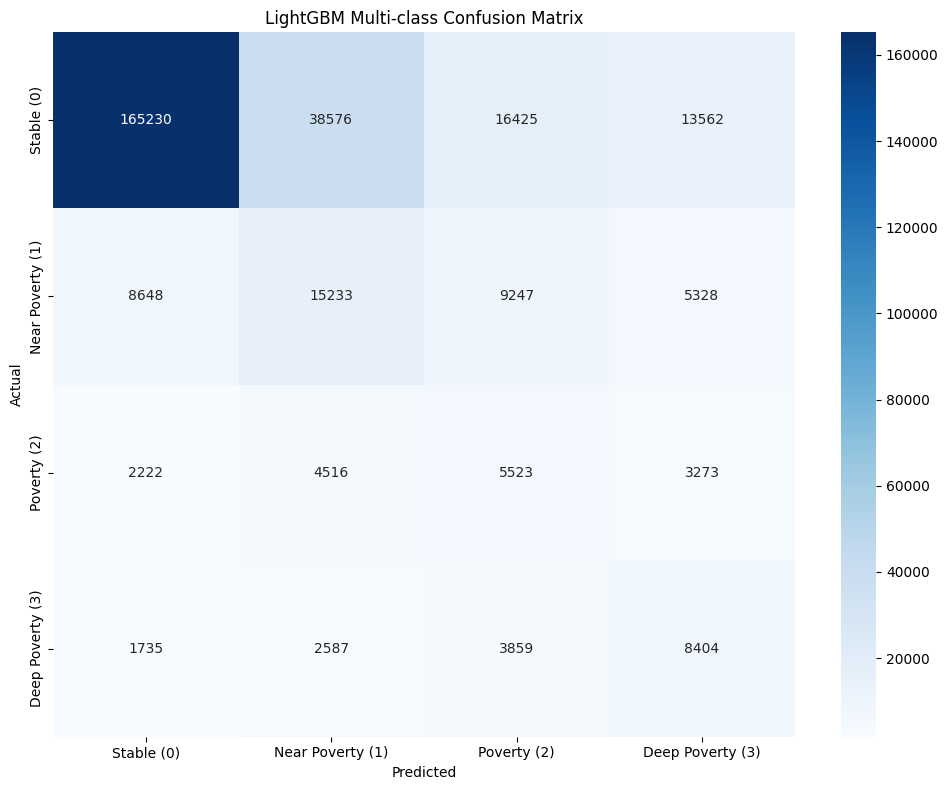

In [25]:
# LightGBM Multi-class Confusion Matrix
cm_lgb = confusion_matrix(y_test_lgb, y_pred_lgb_multi)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM Multi-class Confusion Matrix')
plt.tight_layout()
plt.savefig('preprocessing_data/lightgbm_multiclass_confusion.png', dpi=150)
plt.show()

## 11. LightGBM with Undersampling

Undersampling was the best multi-class strategy in the XGBoost notebooks. Let's try it with LightGBM.

In [26]:
# Undersample majority class
minority_total_lgb = y_train_lgb[y_train_lgb > 0].shape[0]

undersample_strategy_lgb = {
    0: minority_total_lgb,
    1: Counter(y_train_lgb)[1],
    2: Counter(y_train_lgb)[2],
    3: Counter(y_train_lgb)[3]
}

rus_lgb = RandomUnderSampler(sampling_strategy=undersample_strategy_lgb, random_state=42)
X_train_lgb_under, y_train_lgb_under = rus_lgb.fit_resample(X_train_lgb, y_train_lgb)
print(f"After undersampling: {Counter(y_train_lgb_under)}")

model_lgb_under = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,
    metric='multi_logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\nTraining LightGBM on undersampled data...")
model_lgb_under.fit(
    X_train_lgb_under, y_train_lgb_under,
    eval_set=[(X_test_lgb, y_test_lgb)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=True),
        lgb.log_evaluation(period=50)
    ]
)

y_pred_lgb_under = model_lgb_under.predict(X_test_lgb)
print(f"\nBest iteration: {model_lgb_under.best_iteration_}")
print("\n=== LightGBM Undersampling Results ===")
print(classification_report(y_test_lgb, y_pred_lgb_under, target_names=class_names))

After undersampling: Counter({0: 355023, 1: 196583, 3: 79445, 2: 78995})

Training LightGBM on undersampled data...
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.699587
[100]	valid_0's multi_logloss: 0.695585
[150]	valid_0's multi_logloss: 0.694713
Early stopping, best iteration is:
[157]	valid_0's multi_logloss: 0.694661

Best iteration: 157

=== LightGBM Undersampling Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.90      0.82      0.86    233793
Near Poverty (1)       0.29      0.52      0.38     38456
     Poverty (2)       0.27      0.07      0.11     15534
Deep Poverty (3)       0.38      0.40      0.39     16585

        accuracy                           0.72    304368
       macro avg       0.46      0.45      0.43    304368
    weighted avg       0.76      0.72      0.73    304368



## 12. LightGBM Binary Classification (Stable vs At-Risk)

In [27]:
# Binary target
y_train_lgb_binary = (y_train_lgb > 0).astype(int)
y_test_lgb_binary = (y_test_lgb > 0).astype(int)

print(f"Binary At-Risk percentage: {y_train_lgb_binary.mean()*100:.1f}%")

# Undersample for binary
rus_lgb_binary = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_lgb_bin_under, y_train_lgb_bin_under = rus_lgb_binary.fit_resample(X_train_lgb, y_train_lgb_binary)
print(f"After undersampling: {Counter(y_train_lgb_bin_under)}")

model_lgb_binary = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\nTraining LightGBM binary model...")
model_lgb_binary.fit(
    X_train_lgb_bin_under, y_train_lgb_bin_under,
    eval_set=[(X_test_lgb, y_test_lgb_binary)],
    eval_metric='binary_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=True),
        lgb.log_evaluation(period=50)
    ]
)

y_pred_lgb_binary = model_lgb_binary.predict(X_test_lgb)
binary_names = ['Stable', 'At-Risk']

print(f"\nBest iteration: {model_lgb_binary.best_iteration_}")
print("\n=== LightGBM Binary Classification Results ===")
print(classification_report(y_test_lgb_binary, y_pred_lgb_binary, target_names=binary_names))

Binary At-Risk percentage: 24.2%
After undersampling: Counter({0: 710046, 1: 355023})

Training LightGBM binary model...
Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.412192
[100]	valid_0's binary_logloss: 0.407126
[150]	valid_0's binary_logloss: 0.405591
[200]	valid_0's binary_logloss: 0.405007
[250]	valid_0's binary_logloss: 0.404763
[300]	valid_0's binary_logloss: 0.404729
[350]	valid_0's binary_logloss: 0.404672
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.404601

Best iteration: 331

=== LightGBM Binary Classification Results ===
              precision    recall  f1-score   support

      Stable       0.88      0.86      0.87    233793
     At-Risk       0.58      0.63      0.60     70575

    accuracy                           0.81    304368
   macro avg       0.73      0.74      0.74    304368
weighted avg       0.81      0.81      0.81    304368



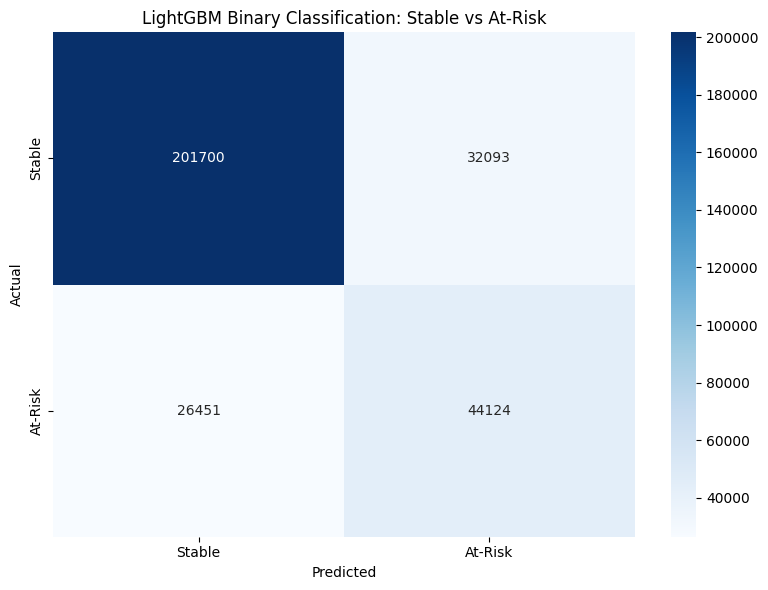

In [28]:
# Binary Confusion Matrix
cm_lgb_binary = confusion_matrix(y_test_lgb_binary, y_pred_lgb_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_names, yticklabels=binary_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM Binary Classification: Stable vs At-Risk')
plt.tight_layout()
plt.savefig('preprocessing_data/lightgbm_binary_confusion.png', dpi=150)
plt.show()

## 13. LightGBM Feature Importance

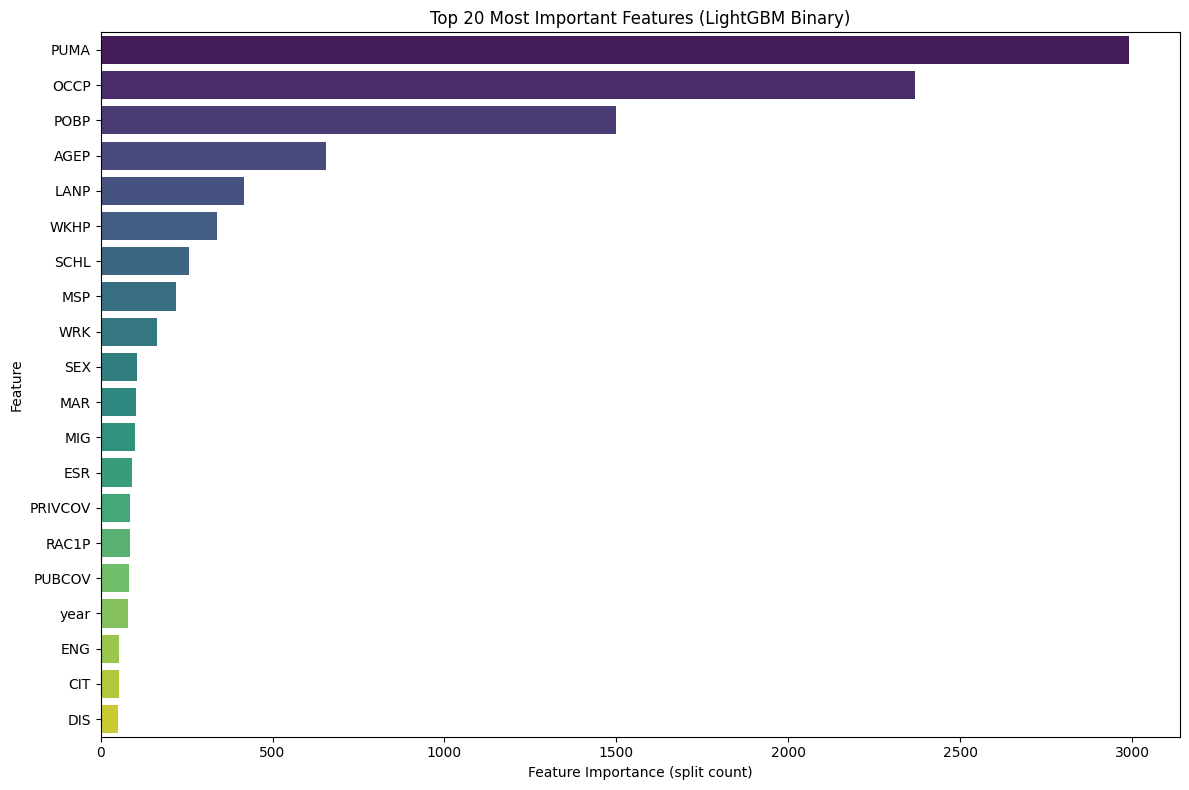


Top 15 Features:
feature  importance
   PUMA        2990
   OCCP        2370
   POBP        1498
   AGEP         655
   LANP         417
   WKHP         338
   SCHL         256
    MSP         219
    WRK         164
    SEX         105
    MAR         102
    MIG         100
    ESR          90
PRIVCOV          85
  RAC1P          84


In [29]:
# Feature importance from binary model
lgb_importance_df = pd.DataFrame({
    'feature': lgb_feature_cols,
    'importance': model_lgb_binary.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=lgb_importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance (split count)')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features (LightGBM Binary)')
plt.tight_layout()
plt.savefig('preprocessing_data/lightgbm_feature_importance.png', dpi=150)
plt.show()

print("\nTop 15 Features:")
print(lgb_importance_df.head(15).to_string(index=False))

## 14. Save LightGBM Models

In [30]:
# Save LightGBM models
model_lgb_multi.booster_.save_model('preprocessing_data/lightgbm_multiclass.txt')
model_lgb_under.booster_.save_model('preprocessing_data/lightgbm_undersampled.txt')
model_lgb_binary.booster_.save_model('preprocessing_data/lightgbm_binary.txt')

print("LightGBM models saved:")
print("  - preprocessing_data/lightgbm_multiclass.txt")
print("  - preprocessing_data/lightgbm_undersampled.txt")
print("  - preprocessing_data/lightgbm_binary.txt")

LightGBM models saved:
  - preprocessing_data/lightgbm_multiclass.txt
  - preprocessing_data/lightgbm_undersampled.txt
  - preprocessing_data/lightgbm_binary.txt


---

## 15. Full Model Comparison: CatBoost vs LightGBM (+ XGBoost Reference)

In [31]:
# Full comparison: CatBoost + LightGBM (+ XGBoost from notebook 4 for reference)
all_results = []

# CatBoost Multi-class
all_results.append({
    'Model': 'CatBoost Multi-class',
    'Task': '4-class',
    'Macro F1': f1_score(y_test, y_pred_multi, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_multi, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_multi)
})

# CatBoost Binary
all_results.append({
    'Model': 'CatBoost Binary',
    'Task': 'Binary',
    'Macro F1': f1_score(y_test_binary, y_pred_binary, average='macro'),
    'Weighted F1': f1_score(y_test_binary, y_pred_binary, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_binary, y_pred_binary)
})

# LightGBM Multi-class (sample weights)
all_results.append({
    'Model': 'LightGBM Multi-class',
    'Task': '4-class',
    'Macro F1': f1_score(y_test_lgb, y_pred_lgb_multi, average='macro'),
    'Weighted F1': f1_score(y_test_lgb, y_pred_lgb_multi, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_lgb, y_pred_lgb_multi)
})

# LightGBM Undersampling
all_results.append({
    'Model': 'LightGBM Undersampled',
    'Task': '4-class',
    'Macro F1': f1_score(y_test_lgb, y_pred_lgb_under, average='macro'),
    'Weighted F1': f1_score(y_test_lgb, y_pred_lgb_under, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_lgb, y_pred_lgb_under)
})

# LightGBM Binary
all_results.append({
    'Model': 'LightGBM Binary',
    'Task': 'Binary',
    'Macro F1': f1_score(y_test_lgb_binary, y_pred_lgb_binary, average='macro'),
    'Weighted F1': f1_score(y_test_lgb_binary, y_pred_lgb_binary, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_lgb_binary, y_pred_lgb_binary)
})

# XGBoost reference scores from notebook 4 (hardcoded from actual run results)
all_results.append({
    'Model': 'XGBoost Best Multi-class*',
    'Task': '4-class',
    'Macro F1': 0.446,
    'Weighted F1': 0.723,
    'Balanced Accuracy': 0.477
})
all_results.append({
    'Model': 'XGBoost Binary*',
    'Task': 'Binary',
    'Macro F1': 0.737,
    'Weighted F1': 0.806,
    'Balanced Accuracy': 0.754
})

all_results_df = pd.DataFrame(all_results)
print("=== Full Model Comparison (Temporal Split) ===")
print("(* XGBoost scores from notebook 4_Preprocessing_XGBoost_Model)")
print()
print(all_results_df.to_string(index=False))

=== Full Model Comparison (Temporal Split) ===
(* XGBoost scores from notebook 4_Preprocessing_XGBoost_Model)

                    Model    Task  Macro F1  Weighted F1  Balanced Accuracy
     CatBoost Multi-class 4-class  0.424542     0.675371           0.502840
          CatBoost Binary  Binary  0.707726     0.765627           0.771312
     LightGBM Multi-class 4-class  0.421057     0.685966           0.491279
    LightGBM Undersampled 4-class  0.433398     0.733215           0.454166
          LightGBM Binary  Binary  0.737222     0.810176           0.743968
XGBoost Best Multi-class* 4-class  0.446000     0.723000           0.477000
          XGBoost Binary*  Binary  0.737000     0.806000           0.754000


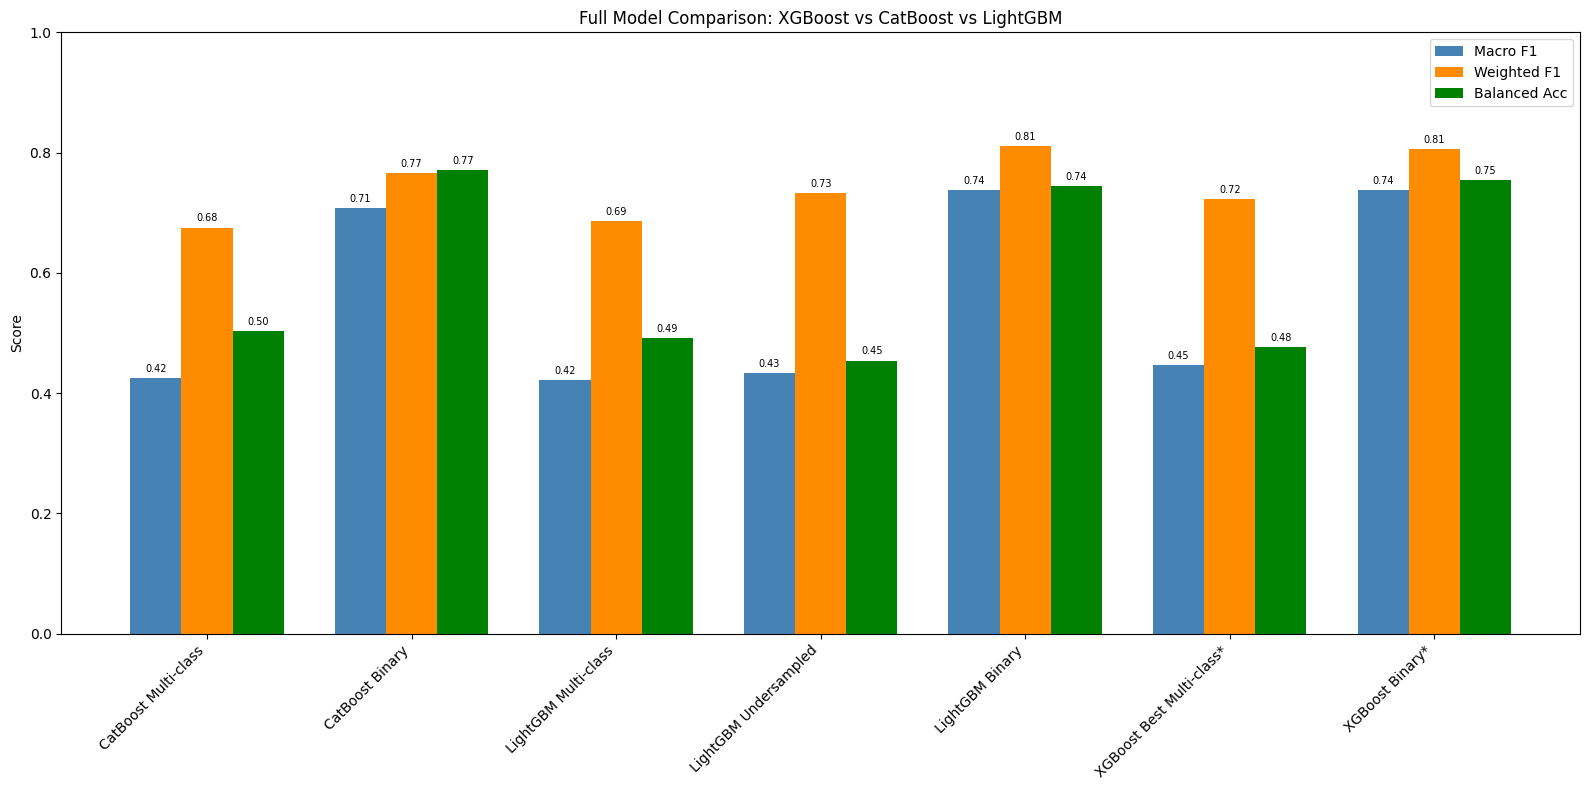

In [32]:
# Visualization: Full model comparison
fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(len(all_results_df))
width = 0.25

bars1 = ax.bar(x - width, all_results_df['Macro F1'], width, label='Macro F1', color='steelblue')
bars2 = ax.bar(x, all_results_df['Weighted F1'], width, label='Weighted F1', color='darkorange')
bars3 = ax.bar(x + width, all_results_df['Balanced Accuracy'], width, label='Balanced Acc', color='green')

ax.set_ylabel('Score')
ax.set_title('Full Model Comparison: XGBoost vs CatBoost vs LightGBM')
ax.set_xticks(x)
ax.set_xticklabels(all_results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('preprocessing_data/full_model_comparison.png', dpi=150)
plt.show()

## Conclusions: XGBoost vs CatBoost vs LightGBM

### Full Results Summary

| Model | Task | Macro F1 | Weighted F1 | Balanced Acc | Accuracy |
|-------|------|----------|-------------|--------------|----------|
| XGBoost Best Multi-class* | 4-class | **0.45** | 0.72 | 0.48 | 71% |
| LightGBM Undersampled | 4-class | 0.43 | **0.73** | 0.45 | 72% |
| CatBoost Multi-class | 4-class | 0.42 | 0.68 | **0.50** | 62% |
| LightGBM Multi-class | 4-class | 0.42 | 0.69 | 0.49 | 64% |
| **LightGBM Binary** | **Binary** | **0.74** | **0.81** | 0.74 | **81%** |
| **XGBoost Binary*** | **Binary** | **0.74** | 0.81 | **0.75** | 80% |
| CatBoost Binary | Binary | 0.71 | 0.77 | 0.77 | 75% |

*\* XGBoost scores from notebook 4_Preprocessing_XGBoost_Model (Pure SMOTE strategy)*

### Key Findings

1. **LightGBM matches XGBoost as the top binary classifier** — Both achieve 0.74 macro F1 and 81% accuracy on the binary task. LightGBM edges out XGBoost slightly on weighted F1 (0.81 vs 0.81) while training significantly faster (early stopping at iteration 331 vs 256 for XGBoost).

2. **All three models hit the same multi-class ceiling (~0.42-0.45 macro F1)** — XGBoost with Pure SMOTE leads at 0.45, but the margin over LightGBM Undersampled (0.43) and CatBoost (0.42) is small. This confirms the ceiling is a **data limitation**, not a model limitation.

3. **CatBoost underperforms on binary classification** — At 0.71 macro F1 vs 0.74 for both XGBoost and LightGBM, CatBoost's native categorical handling did not provide an advantage. Its `auto_class_weights='Balanced'` approach was less effective than the explicit undersampling used by the other models.

4. **LightGBM is dramatically faster** — Early stopping triggered at iteration 157 for undersampled multi-class (vs 312 for XGBoost, 344 for CatBoost). Binary training stopped at 331. The histogram-based splitting and leaf-wise growth give LightGBM a clear speed advantage.

5. **Binary classification dominates across all three models** — The jump from multi-class to binary is consistent: +0.31 macro F1 for LightGBM, +0.29 for XGBoost, +0.28 for CatBoost. Poverty sub-classes have too much feature overlap to separate reliably with these 25 ACS features.

6. **Feature importance differs by model type**:
   - **XGBoost**: PRIVCOV (0.32) dominates, followed by MSP, WKHP, WKL
   - **CatBoost**: WKHP (15.9%), MSP (14.6%), PRIVCOV (14.0%) — more evenly distributed
   - **LightGBM**: PUMA (2990 splits), OCCP (2370), POBP (1498) — geographic and occupation features rank highest by split count
   - All models agree that insurance, employment, and demographic features are the key predictors

### Model Ranking

**Binary Classification (Recommended):**
1. LightGBM Binary — 0.74 macro F1, 81% accuracy, fastest training
2. XGBoost Binary — 0.74 macro F1, 80% accuracy, most strategies tested
3. CatBoost Binary — 0.71 macro F1, 75% accuracy

**Multi-class Classification:**
1. XGBoost (Pure SMOTE) — 0.45 macro F1
2. LightGBM (Undersampled) — 0.43 macro F1
3. CatBoost (Balanced weights) — 0.42 macro F1

### Recommendation
**LightGBM Binary** or **XGBoost Binary** are the recommended models for this project. Both achieve equivalent performance, but LightGBM trains faster while XGBoost has been more thoroughly tested across 6 class imbalance strategies. For a capstone presentation, XGBoost provides the most complete story with all strategy comparisons, while LightGBM demonstrates model diversity and confirms the findings generalize across algorithms.